In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [3]:
def true_1D_FODE(x): #True function for 1D_1 dy/dx = cos(0.01*x) BC1: y(0)=0; x \in [-100,100]
    y = 100*np.sin(0.01*x)
    return y

In [4]:
def true_1D_SODE(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1; x \in [0,2]
    y = np.exp(2*x) + np.exp(-3*x)
    return y

In [5]:
prob_name_disc = 'Regr_disc_'

lb_disc = np.array(-4.0)  # [-1. 0.]
ub_disc = np.array(3.75) # [1.  0.99]

x_test_disc = np.linspace(lb_disc,ub_disc,1000).reshape(-1,1)
u_true_disc = true_disc(x_test_disc)

x_test_tensor_disc = torch.from_numpy(x_test_disc).float().to(device)

In [6]:
prob_name_fode = "1D_FODE_"

x_fode = np.linspace(-600,600,5000).reshape(-1,1)
ysol_fode = true_1D_FODE(x_fode)

bc1_x_fode = np.array(0).reshape(-1,1) 
bc1_y_fode = np.array(0).reshape(-1,1)
x_bc1_train_fode = torch.from_numpy(bc1_x_fode).float().to(device)
y_bc1_train_fode = torch.from_numpy(bc1_y_fode).float().to(device)

 
x_test_fode = x_fode.reshape(-1,1)
x_test_tensor_fode = torch.from_numpy(x_test_fode).float().to(device)

y_true_fode = true_1D_FODE(x_test_fode)
y_true_norm_fode = np.linalg.norm(y_true_fode,2)

# Domain bounds
lb_fode = np.array(x_fode[0]) 
ub_fode = np.array(x_fode[-1]) 

In [7]:
prob_name_sode = "1D_SODE_"

x_sode = np.linspace(0,2,100).reshape(-1,1)
ysol_sode = true_1D_SODE(x_sode)

bc1_x_sode = np.array(0)
bc1_y_sode = np.array(0)
 
x_test_sode = x_sode.reshape(-1,1)
x_test_tensor_sode = torch.from_numpy(x_test_sode).float().to(device)

y_true_sode = true_1D_SODE(x_test_sode)

# Domain bounds
lb_sode = np.array(x_sode[0]) 
ub_sode = np.array(x_sode[-1])

In [8]:
{
    "tags": [
        "hide-input",
    ]
}


class Sequentialmodel_stan_smooth(nn.Module):
    
    def __init__(self,layers_smooth):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_smooth[i], layers_smooth[i+1]) for i in range(len(layers_smooth)-1)])
     
        
        for i in range(len(layers_smooth)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers_smooth[1],len(layers_smooth)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_smooth).float().to(device)
        l_b = torch.from_numpy(lb_smooth).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_smooth)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_smooth)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1),2)/u_true_norm_smooth
        
        return test_mse_loss, test_re_loss  
#--------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh_smooth(nn.Module):
    
    def __init__(self,layers_smooth):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_smooth[i], layers_smooth[i+1]) for i in range(len(layers_smooth)-1)])
     
        
        for i in range(len(layers_smooth)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_smooth).float().to(device)
        l_b = torch.from_numpy(lb_smooth).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_smooth)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_smooth)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1),2)/u_true_norm_smooth
        
        return test_mse_loss, test_re_loss  
#-----------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh_smooth(nn.Module):
    
    def __init__(self,layers_smooth):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_smooth[i], layers_smooth[i+1]) for i in range(len(layers_smooth)-1)])
     
        
        for i in range(len(layers_smooth)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.alpha = Parameter(torch.ones((layers_smooth[1],len(layers_smooth)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(10.0)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_smooth).float().to(device)
        l_b = torch.from_numpy(lb_smooth).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_smooth)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_smooth)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1),2)/u_true_norm_smooth
        
        return test_mse_loss, test_re_loss  
#-------------------------------------------------------------------------------------------------------------
class Sequentialmodel_swish_smooth(nn.Module):
    
    def __init__(self,layers_smooth):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_smooth[i], layers_smooth[i+1]) for i in range(len(layers_smooth)-1)])
     
        
        for i in range(len(layers_smooth)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers_smooth[1],len(layers_smooth)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_smooth).float().to(device)
        l_b = torch.from_numpy(lb_smooth).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_smooth)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_smooth)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1),2)/u_true_norm_smooth
        
        return test_mse_loss, test_re_loss  
#-------------------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy_smooth(nn.Module):
    
    def __init__(self,layers_smooth):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_smooth[i], layers_smooth[i+1]) for i in range(len(layers_smooth)-1)])
     
        
        for i in range(len(layers_smooth)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.omega1 = Parameter(torch.ones((len(layers_smooth)-2,1))) 

        
        self.alpha = Parameter(torch.zeros(rowdy_terms_smooth,len(layers_smooth)-2))
        self.omega = Parameter(0.1*torch.ones(rowdy_terms_smooth,len(layers_smooth)-2))
        
        self.n = torch.tensor(10.0)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_smooth).float().to(device)
        l_b = torch.from_numpy(lb_smooth).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_smooth)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms_smooth):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_smooth)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_smooth.reshape(-1,1),2)/u_true_norm_smooth
        
        return test_mse_loss, test_re_loss  

In [9]:
{
    "tags": [
        "hide-input",
    ]
}


class Sequentialmodel_stan_disc(nn.Module):
    
    def __init__(self,layers_disc):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_disc[i], layers_disc[i+1]) for i in range(len(layers_disc)-1)])
     
        
        for i in range(len(layers_disc)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers_disc[1],len(layers_disc)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_disc).float().to(device)
        l_b = torch.from_numpy(lb_disc).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_disc)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_disc)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1),2)/u_true_norm_disc
        
        return test_mse_loss, test_re_loss  
#--------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh_disc(nn.Module):
    
    def __init__(self,layers_disc):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_disc[i], layers_disc[i+1]) for i in range(len(layers_disc)-1)])
     
        
        for i in range(len(layers_disc)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_disc).float().to(device)
        l_b = torch.from_numpy(lb_disc).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_disc)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_disc)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1),2)/u_true_norm_disc
        
        return test_mse_loss, test_re_loss  
#-----------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh_disc(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_disc[i], layers_disc[i+1]) for i in range(len(layers_disc)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.alpha = Parameter(torch.ones((layers_disc[1],len(layers_disc)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(10.0)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_disc).float().to(device)
        l_b = torch.from_numpy(lb_disc).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_disc)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_disc)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1),2)/u_true_norm_disc
        
        return test_mse_loss, test_re_loss  
#-------------------------------------------------------------------------------------------------------------
class Sequentialmodel_swish_disc(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_disc[i], layers_disc[i+1]) for i in range(len(layers_disc)-1)])
     
        
        for i in range(len(layers_disc)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers_disc[1],len(layers_disc)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_disc).float().to(device)
        l_b = torch.from_numpy(lb_disc).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_disc)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_disc)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1),2)/u_true_norm_disc
        
        return test_mse_loss, test_re_loss  
#-------------------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy_disc(nn.Module):
    
    def __init__(self,layers_disc,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_disc[i], layers_disc[i+1]) for i in range(len(layers_disc)-1)])
     
        
        for i in range(len(layers_disc)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.omega1 = Parameter(torch.ones((len(layers_disc)-2,1))) 

        
        self.alpha = Parameter(torch.zeros(rowdy_terms_disc,len(layers_disc)-2))
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms_disc,len(layers_disc)-2))
        
        self.n = torch.tensor(n_val)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_disc).float().to(device)
        l_b = torch.from_numpy(lb_disc).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_disc)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms_disc):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor_disc)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true_disc.reshape(-1,1),2)/u_true_norm_disc
        
        return test_mse_loss, test_re_loss  

In [10]:
{
    "tags": [
        "hide-input",
    ]
}

class Sequentialmodel_stan_fode(nn.Module):
    
    def __init__(self,layers_fode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_fode[i], layers_fode[i+1]) for i in range(len(layers_fode)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers_fode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((50,len(layers_fode)-2)))
        self.beta.requiresGrad = True
        
        self.iter = 0
        
              
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_fode).float().to(device)
        l_b = torch.from_numpy(lb_fode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_fode)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - torch.cos(0.01*g)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + 100*loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor_fode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
       
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1)))
      
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1),2)/y_true_norm_fode
        
        return test_mse, test_re 

#------------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh_fode(nn.Module):
    
    def __init__(self,layers_fode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_fode[i], layers_fode[i+1]) for i in range(len(layers_fode)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers_fode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
             
      
              
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_fode).float().to(device)
        l_b = torch.from_numpy(lb_fode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_fode)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - torch.cos(0.01*g)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + 100*loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor_fode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1),2)/y_true_norm_fode
        
        return test_mse, test_re 
#--------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh_fode(nn.Module):
    
    def __init__(self,layers_fode,n_val):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_fode[i], layers_fode[i+1]) for i in range(len(layers_fode)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers_fode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.alpha = Parameter(torch.ones((50,len(layers_fode)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)
        
              
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_fode).float().to(device)
        l_b = torch.from_numpy(lb_fode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_fode)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - torch.cos(0.01*g)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + 100*loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor_fode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
       
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1)))
      
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1),2)/y_true_norm_fode
        
        return test_mse, test_re 

#------------------------------------------------------------------------------------------
class Sequentialmodel_swish_fode(nn.Module):
    
    def __init__(self,layers_fode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Sigmoid()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_fode[i], layers_fode[i+1]) for i in range(len(layers_fode)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers_fode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((50,len(layers_fode)-2)))
        self.beta.requiresGrad = True
        
              
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_fode).float().to(device)
        l_b = torch.from_numpy(lb_fode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_fode)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - torch.cos(0.01*g)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + 100*loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor_fode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
       
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1)))
      
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1),2)/y_true_norm_fode
        
        return test_mse, test_re 

#----------------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy_fode(nn.Module):
    
    def __init__(self,layers_fode,n_val_fode,rowdy_terms_fode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_fode[i], layers_fode[i+1]) for i in range(len(layers_fode)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers_fode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.omega1 = Parameter(torch.ones((len(layers_fode)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms_fode,len(layers_fode)-2))
        self.alpha.requiresGrad = True
        
        self.omega = Parameter((1/n_val_fode)*torch.ones(rowdy_terms_fode,len(layers_fode)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val_fode)

                      
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_fode).float().to(device)
        l_b = torch.from_numpy(lb_fode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_fode)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms_fode):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - torch.cos(0.01*g)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + 100*loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor_fode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
       
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1)))
      
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_fode.reshape(-1,1),2)/y_true_norm_fode
        
        return test_mse, test_re 

In [11]:
class Sequentialmodel_stan_sode(nn.Module):
    
    def __init__(self,layers_sode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_sode[i], layers_sode[i+1]) for i in range(len(layers_sode)-1)])
        
        for i in range(len(layers_sode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((50,len(layers_sode)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_sode).float().to(device)
        l_b = torch.from_numpy(lb_sode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_sode)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor_sode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1),2)/y_true_norm_sode
        
        return test_mse, test_re

#--------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh_sode(nn.Module):
    
    def __init__(self,layers_sode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_sode[i], layers_sode[i+1]) for i in range(len(layers_sode)-1)])
        
        for i in range(len(layers_sode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 

    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_sode).float().to(device)
        l_b = torch.from_numpy(lb_sode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_sode)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor_sode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1),2)/y_true_norm_sode
        
        return test_mse, test_re

#-----------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh_sode(nn.Module):
    
    def __init__(self,layers_sode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_sode[i], layers_sode[i+1]) for i in range(len(layers_sode)-1)])
        
        for i in range(len(layers_sode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.alpha = Parameter(torch.ones((50,len(layers_sode)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(3.0)
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_sode).float().to(device)
        l_b = torch.from_numpy(lb_sode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_sode)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor_sode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1),2)/y_true_norm_sode
        
        return test_mse, test_re
#----------------------------------------------------------------------------------------
class Sequentialmodel_swish_sode(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Sigmoid()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_sode[i], layers_sode[i+1]) for i in range(len(layers_sode)-1)])
        
        for i in range(len(layers_sode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((layers_sode[1],len(layers_sode)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_sode).float().to(device)
        l_b = torch.from_numpy(lb_sode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_sode)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor_sode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1),2)/y_true_norm_sode
        
        return test_mse, test_re

#--------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy_sode(nn.Module):
    
    def __init__(self,layers_sode,n_val_sode,rowdy_terms_sode):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers_sode[i], layers_sode[i+1]) for i in range(len(layers_sode)-1)])
        
        for i in range(len(layers_sode)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        
        self.omega1 = Parameter(torch.ones((len(layers_sode)-2,1))) 
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms_sode,len(layers_sode)-2))
        self.omega = Parameter((1/n_val_sode)*torch.ones(rowdy_terms_sode,len(layers_sode)-2))
        
        self.n = torch.tensor(n_val_sode)
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub_sode).float().to(device)
        l_b = torch.from_numpy(lb_sode).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers_sode)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms_sode):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor_sode)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true_sode.reshape(-1,1),2)/y_true_norm_sode
        
        return test_mse, test_re

In [12]:
layers_disc = np.array([1,50,50,50,50,1]) #9 hidden layers

rowdy_terms_disc = 2

n_val_rowdy_disc = 1

model_stan_disc = Sequentialmodel_stan_disc(layers_disc )
model_tanh_disc = Sequentialmodel_tanh_disc(layers_disc )
model_atanh_disc = Sequentialmodel_atanh_disc(layers_disc )
model_swish_disc = Sequentialmodel_swish_disc(layers_disc )
model_rowdy_disc = Sequentialmodel_rowdy_disc(layers_disc,n_val_rowdy_disc,rowdy_terms_disc)

u_pred_stan_disc = np.zeros((x_test_disc.shape[0],1))
u_pred_tanh_disc = np.zeros((x_test_disc.shape[0],1))
u_pred_atanh_disc = np.zeros((x_test_disc.shape[0],1))
u_pred_swish_disc = np.zeros((x_test_disc.shape[0],1))
u_pred_rowdy_disc = np.zeros((x_test_disc.shape[0],1))

n_models_disc = 10



folder_base_disc = "./Regression/Discontinuous1/"

for i in range(10):
    model_stan_disc.load_state_dict(torch.load(folder_base_disc + prob_name_disc + 'Stan_' +str(i)+'.pt'))
    u_pred_stan_disc = u_pred_stan_disc + model_stan_disc.test()
    
    model_tanh_disc.load_state_dict(torch.load(folder_base_disc +prob_name_disc + 'tanh_' +str(i)+'.pt'))
    u_pred_tanh_disc = u_pred_tanh_disc + model_tanh_disc.test()
    
    model_atanh_disc.load_state_dict(torch.load(folder_base_disc +prob_name_disc + 'atanh_' +str(i)+'.pt'))
    u_pred_atanh_disc = u_pred_atanh_disc + model_atanh_disc.test()
    
    model_swish_disc.load_state_dict(torch.load(folder_base_disc +prob_name_disc + 'swish_'+str(i)+'.pt'))
    u_pred_swish_disc = u_pred_swish_disc + model_swish_disc.test()
    
    model_rowdy_disc.load_state_dict(torch.load(folder_base_disc +prob_name_disc + 'rowdy_'+str(i)+'.pt'))
    u_pred_rowdy_disc = u_pred_rowdy_disc + model_rowdy_disc.test()

u_pred_stan_disc = u_pred_stan_disc/n_models_disc
u_pred_tanh_disc = u_pred_tanh_disc/n_models_disc
u_pred_atanh_disc = u_pred_atanh_disc/n_models_disc
u_pred_swish_disc = u_pred_swish_disc/n_models_disc
u_pred_rowdy_disc = u_pred_rowdy_disc/n_models_disc

u_pred_disc = np.hstack((u_pred_stan_disc,u_pred_tanh_disc,u_pred_atanh_disc,u_pred_swish_disc,u_pred_rowdy_disc))

FileNotFoundError: [Errno 2] No such file or directory: './Regression/Discontinuous1/Regr_disc_Stan_0.pt'

In [13]:
layers_fode = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

n_val_fode = 8.0
rowdy_terms_fode = 2


model_stan_fode = Sequentialmodel_stan_fode(layers_fode)
model_tanh_fode = Sequentialmodel_tanh_fode(layers_fode)
model_atanh_fode = Sequentialmodel_atanh_fode(layers_fode,1.0)
model_swish_fode = Sequentialmodel_swish_fode(layers_fode)
model_rowdy_fode = Sequentialmodel_rowdy_fode(layers_fode,n_val_fode,rowdy_terms_fode)

y_pred_stan_fode = np.zeros((x_test_fode.shape[0],1))
y_pred_tanh_fode = np.zeros((x_test_fode.shape[0],1))
y_pred_atanh_fode = np.zeros((x_test_fode.shape[0],1))
y_pred_swish_fode = np.zeros((x_test_fode.shape[0],1))
y_pred_rowdy_fode = np.zeros((x_test_fode.shape[0],1))

n_models_fode = 10

folder_base_fode = "./1D/FODE/"

for i in range(10):
    model_stan_fode.load_state_dict(torch.load(folder_base_fode + '/stan/1D_FODE_stan__'+str(i)+'.pt'))
    y_pred_stan_fode = y_pred_stan_fode + model_stan_fode.test()
    
    model_tanh_fode.load_state_dict(torch.load(folder_base_fode + '/tanh/1D_FODE_tanh__'+str(i)+'.pt'))
    y_pred_tanh_fode = y_pred_tanh_fode + model_tanh_fode.test()
    
    model_atanh_fode.load_state_dict(torch.load(folder_base_fode +'/atanh/1D_FODE_atanh__'+str(i)+'.pt'))
    y_pred_atanh_fode = y_pred_atanh_fode + model_atanh_fode.test()
    
    model_swish_fode.load_state_dict(torch.load(folder_base_fode +'/swish/1D_FODE_swish__'+str(i)+'.pt'))
    y_pred_swish_fode = y_pred_swish_fode + model_swish_fode.test()
    
    model_rowdy_fode.load_state_dict(torch.load(folder_base_fode +'/rowdy/1D_FODE_rowdy_'+str(i)+'.pt'))
    y_pred_rowdy_fode = y_pred_rowdy_fode + model_rowdy_fode.test()
    


y_pred_stan_fode = y_pred_stan_fode/n_models_fode
y_pred_tanh_fode = y_pred_tanh_fode/n_models_fode
y_pred_atanh_fode = y_pred_atanh_fode/n_models_fode
y_pred_swish_fode = y_pred_swish_fode/n_models_fode
y_pred_rowdy_fode = y_pred_rowdy_fode/n_models_fode

y_pred_fode = np.hstack((y_pred_stan_fode,y_pred_tanh_fode,y_pred_atanh_fode,y_pred_swish_fode,y_pred_rowdy_fode))

FileNotFoundError: [Errno 2] No such file or directory: './1D/FODE//stan/1D_FODE_stan__0.pt'

In [14]:
layers_sode = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

rowdy_terms_sode = 2
n_val_rowdy_sode = 5

n_val_sode = 5.0

model_stan_sode = Sequentialmodel_stan_sode(layers_sode)
model_tanh_sode = Sequentialmodel_tanh_sode(layers_sode)
model_atanh_sode = Sequentialmodel_atanh_sode(layers_sode)
model_swish_sode = Sequentialmodel_swish_sode(layers_sode)
model_rowdy_sode = Sequentialmodel_rowdy_sode(layers_sode,n_val_rowdy_sode,rowdy_terms_sode)

y_pred_stan_sode = np.zeros((x_test_sode.shape[0],1))
y_pred_tanh_sode = np.zeros((x_test_sode.shape[0],1))
y_pred_atanh_sode = np.zeros((x_test_sode.shape[0],1))
y_pred_swish_sode = np.zeros((x_test_sode.shape[0],1))
y_pred_rowdy_sode = np.zeros((x_test_sode.shape[0],1))

n_models_sode = 10


folder_base_sode = "./1D/SODE/"

for i in range(10):
    model_stan_sode.load_state_dict(torch.load(folder_base_sode + '/stan/1D_SODE_Stan_'+str(i)+'.pt'))
    y_pred_stan_sode = y_pred_stan_sode + model_stan_sode.test()
    
    model_tanh_sode.load_state_dict(torch.load(folder_base_sode + '/tanh/1D_SODE_tanh_'+str(i)+'.pt'))
    y_pred_tanh_sode = y_pred_tanh_sode + model_tanh_sode.test()
    
    model_atanh_sode.load_state_dict(torch.load(folder_base_sode + '/atanh/1D_SODE_atanh_'+str(i)+'.pt'))
    y_pred_atanh_sode = y_pred_atanh_sode + model_atanh_sode.test()
    
    model_swish_sode.load_state_dict(torch.load(folder_base_sode + '/swish/1D_SODE_swish_'+str(i)+'.pt'))
    y_pred_swish_sode = y_pred_swish_sode + model_swish_sode.test()
    
    model_rowdy_sode.load_state_dict(torch.load(folder_base_sode + '/rowdy/1D_SODE_rowdy_'+str(i)+'.pt'))
    y_pred_rowdy_sode = y_pred_rowdy_sode + model_rowdy_sode.test()
    


y_pred_stan_sode = y_pred_stan_sode/n_models_sode
y_pred_tanh_sode = y_pred_tanh_sode/n_models_sode
y_pred_atanh_sode = y_pred_atanh_sode/n_models_sode
y_pred_swish_sode = y_pred_swish_sode/n_models_sode
y_pred_rowdy_sode = y_pred_rowdy_sode/n_models_sode

y_pred_sode = np.hstack((y_pred_stan_sode,y_pred_tanh_sode,y_pred_atanh_sode,y_pred_swish_sode,y_pred_rowdy_sode))

FileNotFoundError: [Errno 2] No such file or directory: './1D/SODE//stan/1D_SODE_Stan_0.pt'

NameError: name 'u_pred_disc' is not defined

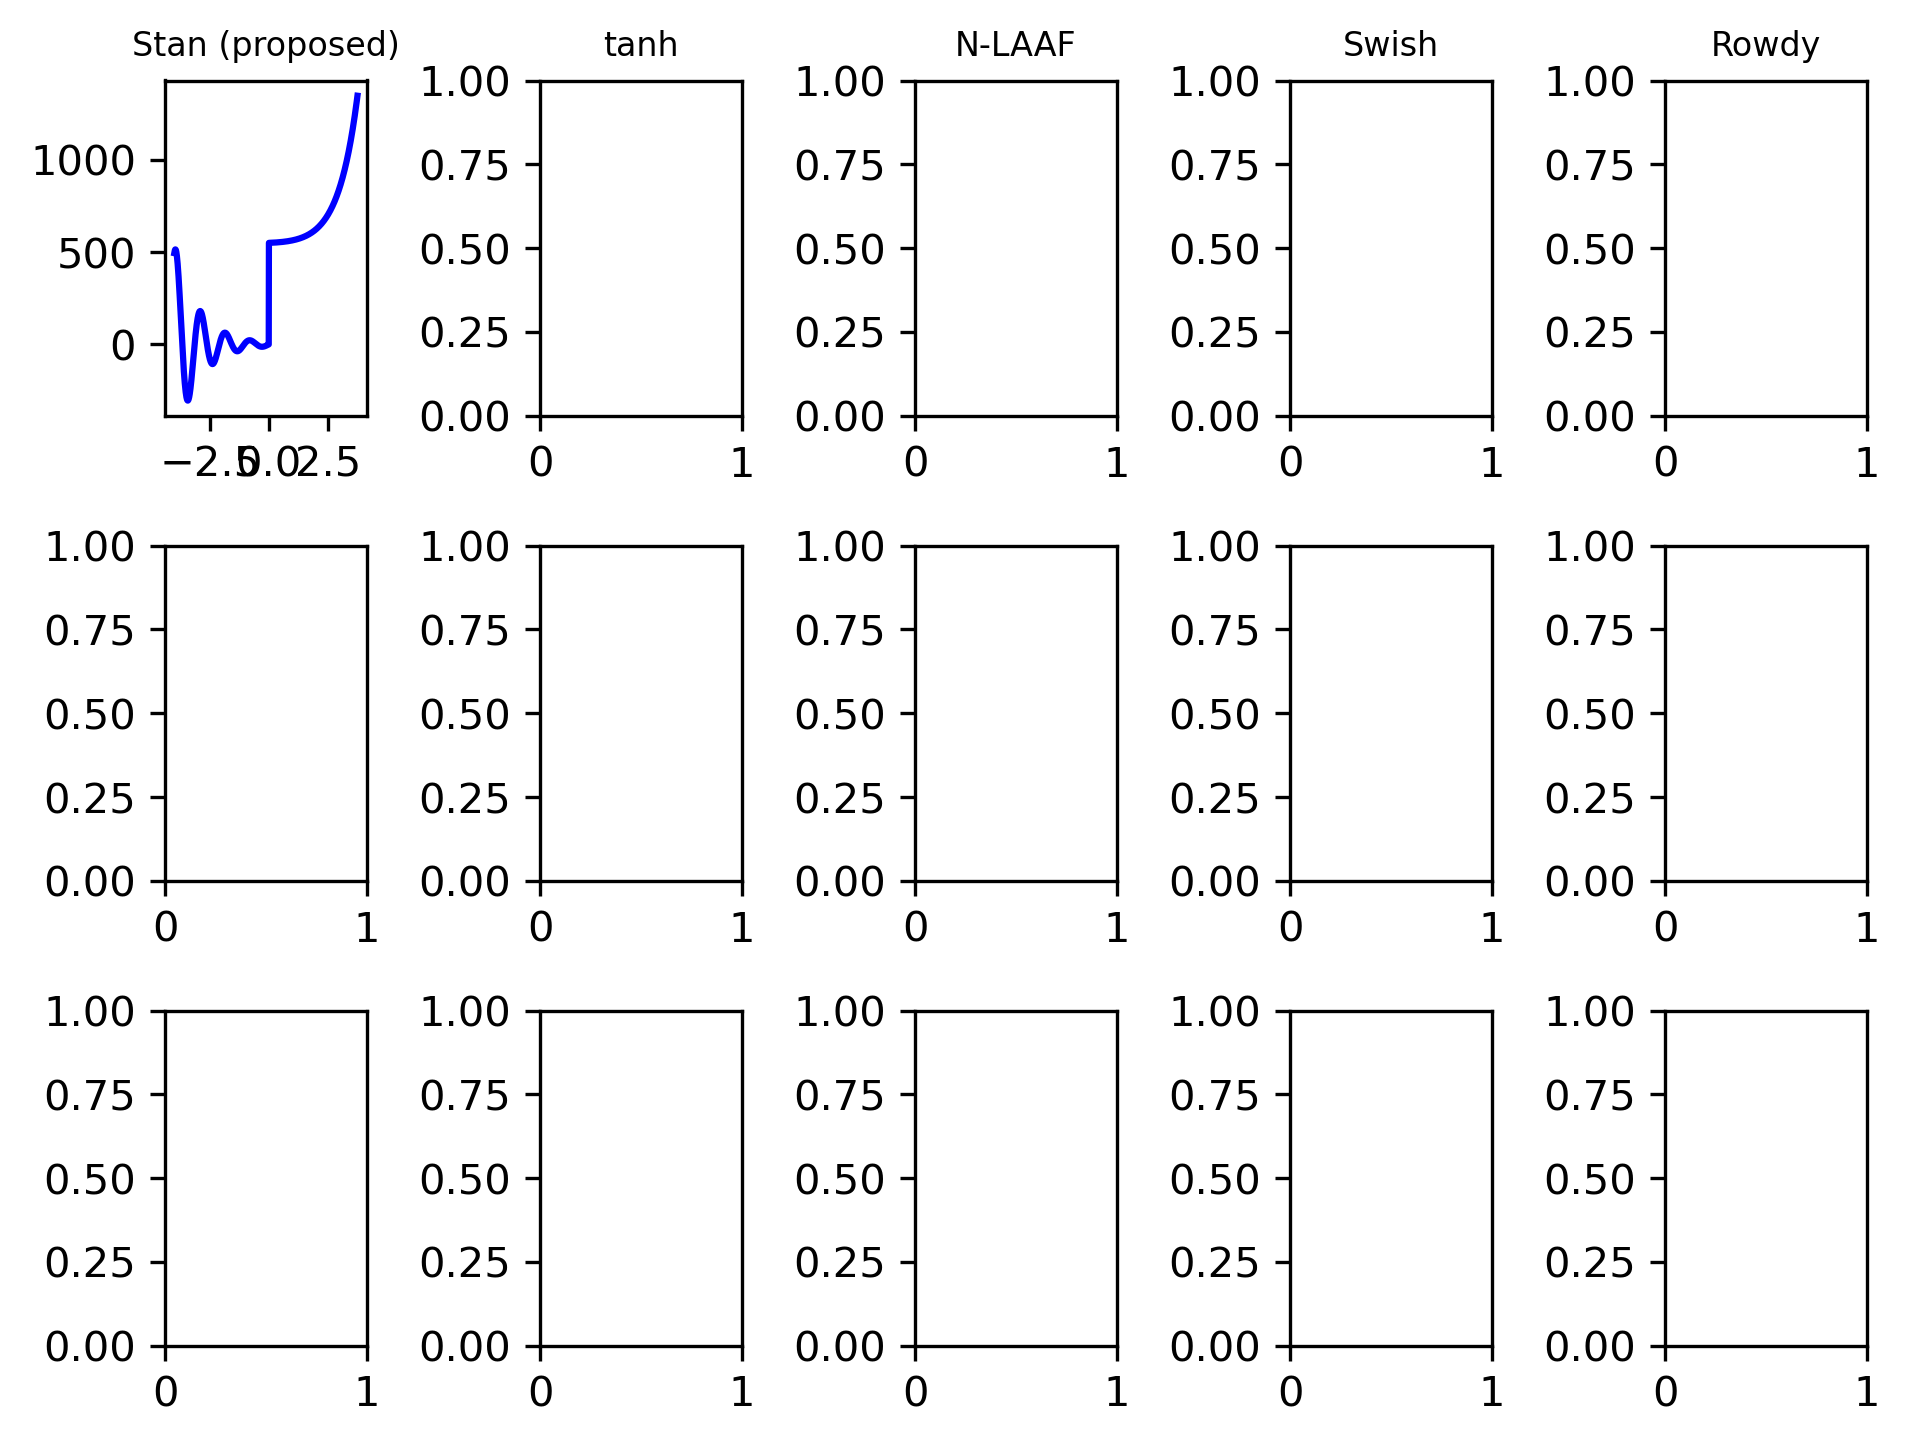

In [15]:
fig, ax = plt.subplots(3,5)

fig.dpi=300
fig.tight_layout()

# R = 0

# # ax[R,0].set_aspect(aspect = 1/80)
# # ax[R,0].axis('off')
# # ax[R,0].text(0,0.5,"Smooth \nFunction",fontsize=8)
# #ax[0].text(0,0.45,"Function",fontsize=8)

# for i in range(5):
#     ax[R,i].plot(x_test_smooth,u_true_smooth,'b',linewidth = 1.5,label = 'Exact')
#     ax[R,i].plot(x_test_smooth,u_pred_smooth[:,i-1],'r-.',linewidth = 1.5,label = "Prediction")
    
#     ax[R,i].set_xlabel('$x$', fontsize=6, math_fontfamily='cm', labelpad=0.0)
#     ax[R,i].set_ylabel(' $u(x)$',fontsize=6, math_fontfamily='cm', labelpad=0.0)
    
#     ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
#     ax[R,i].tick_params(axis='y', labelsize=3,length = 1)
    
#     ax[R,i].set_aspect(aspect = 1/80)
    
#     ax[R,i].yaxis.set_label_coords(-0.15,0.5)
    
#     ax[R,i].legend(prop={'size':3},loc = 'upper center')





#--------------------------------------------------------------------------------------------------------
  
R = 0

# ax[R,0].set_aspect(aspect = 1/80)
# ax[R,0].axis('off')
# ax[R,0].text(0,0.5,"Discontinuous \nFunction",fontsize=8)

ax[R,0].set_title('Stan (proposed)',fontsize=8, math_fontfamily='cm')
ax[R,1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[R,2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[R,3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[R,4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

for i in range(5):
    ax[R,i].plot(x_test_disc,u_true_disc,'b',linewidth = 1.5,label = 'Exact')
    ax[R,i].plot(x_test_disc,u_pred_disc[:,i],'r-.',linewidth = 1.5,label = "Prediction")
    
    ax[R,i].set_xlabel('$x$', fontsize=6, math_fontfamily='cm', labelpad=0.0)
    ax[R,i].set_ylabel(' $u(x)$',fontsize=6, math_fontfamily='cm', labelpad=0.0)
    
    ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
    ax[R,i].tick_params(axis='y', labelsize=3,length = 1)
    
    ax[R,i].set_aspect(aspect = 1/250)
    
    ax[R,i].yaxis.set_label_coords(-0.15,0.5)
    
    ax[R,i].legend(prop={'size':3},loc = 'upper left')

    ax[R,i].set_ylim([-300,1350])
    ax[R,i].set_xlim([-4,3.75])
#------------------------------------------------------------------------------------------------------------    
R=1
# ax[R,0].set_aspect(aspect = 1/80)
# ax[R,0].axis('off')
# ax[R,0].text(0,0.5,"First-order \nODE",fontsize=8)


for i in range(5):
    ax[R,i].plot(x_test_fode,y_true_fode,'b',linewidth = 1.5,label = 'Exact')
    ax[R,i].plot(x_test_fode,y_pred_fode[:,i],'r-.',linewidth = 1.5,label = "Prediction")
    
    ax[R,i].set_xlabel('$x$', fontsize=6, math_fontfamily='cm', labelpad=0.0)
    ax[R,i].set_ylabel(' $u(x)$',fontsize=6, math_fontfamily='cm', labelpad=0.0)
    
    ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
    ax[R,i].tick_params(axis='y', labelsize=3,length = 1)
    
    ax[R,i].set_aspect(aspect = 4)
    
    ax[R,i].yaxis.set_label_coords(-0.15,0.5)
    
    ax[R,i].legend(prop={'size':3}, loc = 'upper right')
    
    ax[R,i].set_xlim([lb_fode,ub_fode])
#------------------------------------------------------------------------------------------------------------    
R=2

# ax[R,0].set_aspect(aspect = 1/80)
# ax[R,0].axis('off')
# ax[R,0].text(0,0.5,"Second-order \nODE",fontsize=8)

for i in range(5):
    ax[R,i].plot(x_test_sode,y_true_sode,'b',linewidth = 1.5,label = 'Exact')
    ax[R,i].plot(x_test_sode,y_pred_sode[:,i],'r-.',linewidth = 1.5,label = "Prediction")
    
    ax[R,i].set_xlabel('$x$', fontsize=6, math_fontfamily='cm', labelpad=0.0)
    ax[R,i].set_ylabel(' $u(x)$',fontsize=6, math_fontfamily='cm', labelpad=0.0)
    
    ax[R,i].tick_params(axis='x', labelsize=3,length = 1)
    ax[R,i].tick_params(axis='y', labelsize=3,length = 1)
    
    ax[R,i].set_aspect(aspect = 1/40)
    
    
    ax[R,i].yaxis.set_label_coords(-0.15,0.5)
    
    ax[R,i].legend(prop={'size':3}, loc = 'upper left')
    
    ax[R,i].set_xlim([lb_sode,ub_sode])
    


plot_rows = ['(a)','(b)','(c)','(d)']

for i in range(3):
    ax[i,0].text(-0.5,0.5,plot_rows[i],fontsize=8,transform=ax[i,0].transAxes)



fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=-0.5)
# plt.savefig('1D_predictions.pdf', format='pdf',pad_inches=0, bbox_inches='tight')
plt.savefig('1D_predictions.svg', format='svg',pad_inches=0, bbox_inches='tight')